This project is to predict if the page is being flipped using a single image.

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping. 

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

# Table of contents
- [Verify GPU](#gpu)
- [Data Pipeline](#pipe)
- [Bayesian Optimization](#tuning)
- [Model evaluation](#eva)
- [Conclusion](#con)

In [1]:
import numpy as np
import sys
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
import platform
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import keras_tuner
from keras_tuner import BayesianOptimization
import pathlib
import matplotlib.pyplot as plt
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')
print()
print(f'python {sys.version}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sk.__version__}')
gpu=len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'not avail')

Using TensorFlow backend
Python platform: macOS-14.0-arm64-arm-64bit
Tensorflow version: 2.14.0

python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
pandas 2.1.1
scikit-learn 1.3.0
GPU is available


In [3]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
set_random_seed(123)

# Verify GPU <a class="anchor" id="gpu"></a>

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# GPU of my machine that is visible to TensorFlow
print('GPU name:',tf.test.gpu_device_name())

Num GPUs Available:  1
GPU name: /device:GPU:0


2023-10-31 19:44:17.436323: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-31 19:44:17.436343: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-31 19:44:17.436347: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-31 19:44:17.436512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-31 19:44:17.436525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Data Pipeline <a class="anchor" id="pipe"></a>

In [5]:
training_notflip = os.listdir('../APZIVA/images/training/notflip')
training_flip = os.listdir('../APZIVA/images/training/flip')
testing_notflip = os.listdir('../APZIVA/images/testing/notflip')
testing_flip = os.listdir('../APZIVA/images/testing/flip')

print(len(training_flip) + len(training_notflip), 'images in training set')
print(f'({len(training_flip)} flipped images and {len(training_notflip)} non-flipped images)')
print()
print(len(testing_flip)+len(testing_notflip),'images in testing set')
print(f'({len(testing_flip)} flipped images and {len(testing_notflip)} non-flipped images)')

2392 images in training set
(1162 flipped images and 1230 non-flipped images)

597 images in testing set
(290 flipped images and 307 non-flipped images)


We can see that the dataset is pretty balanced.

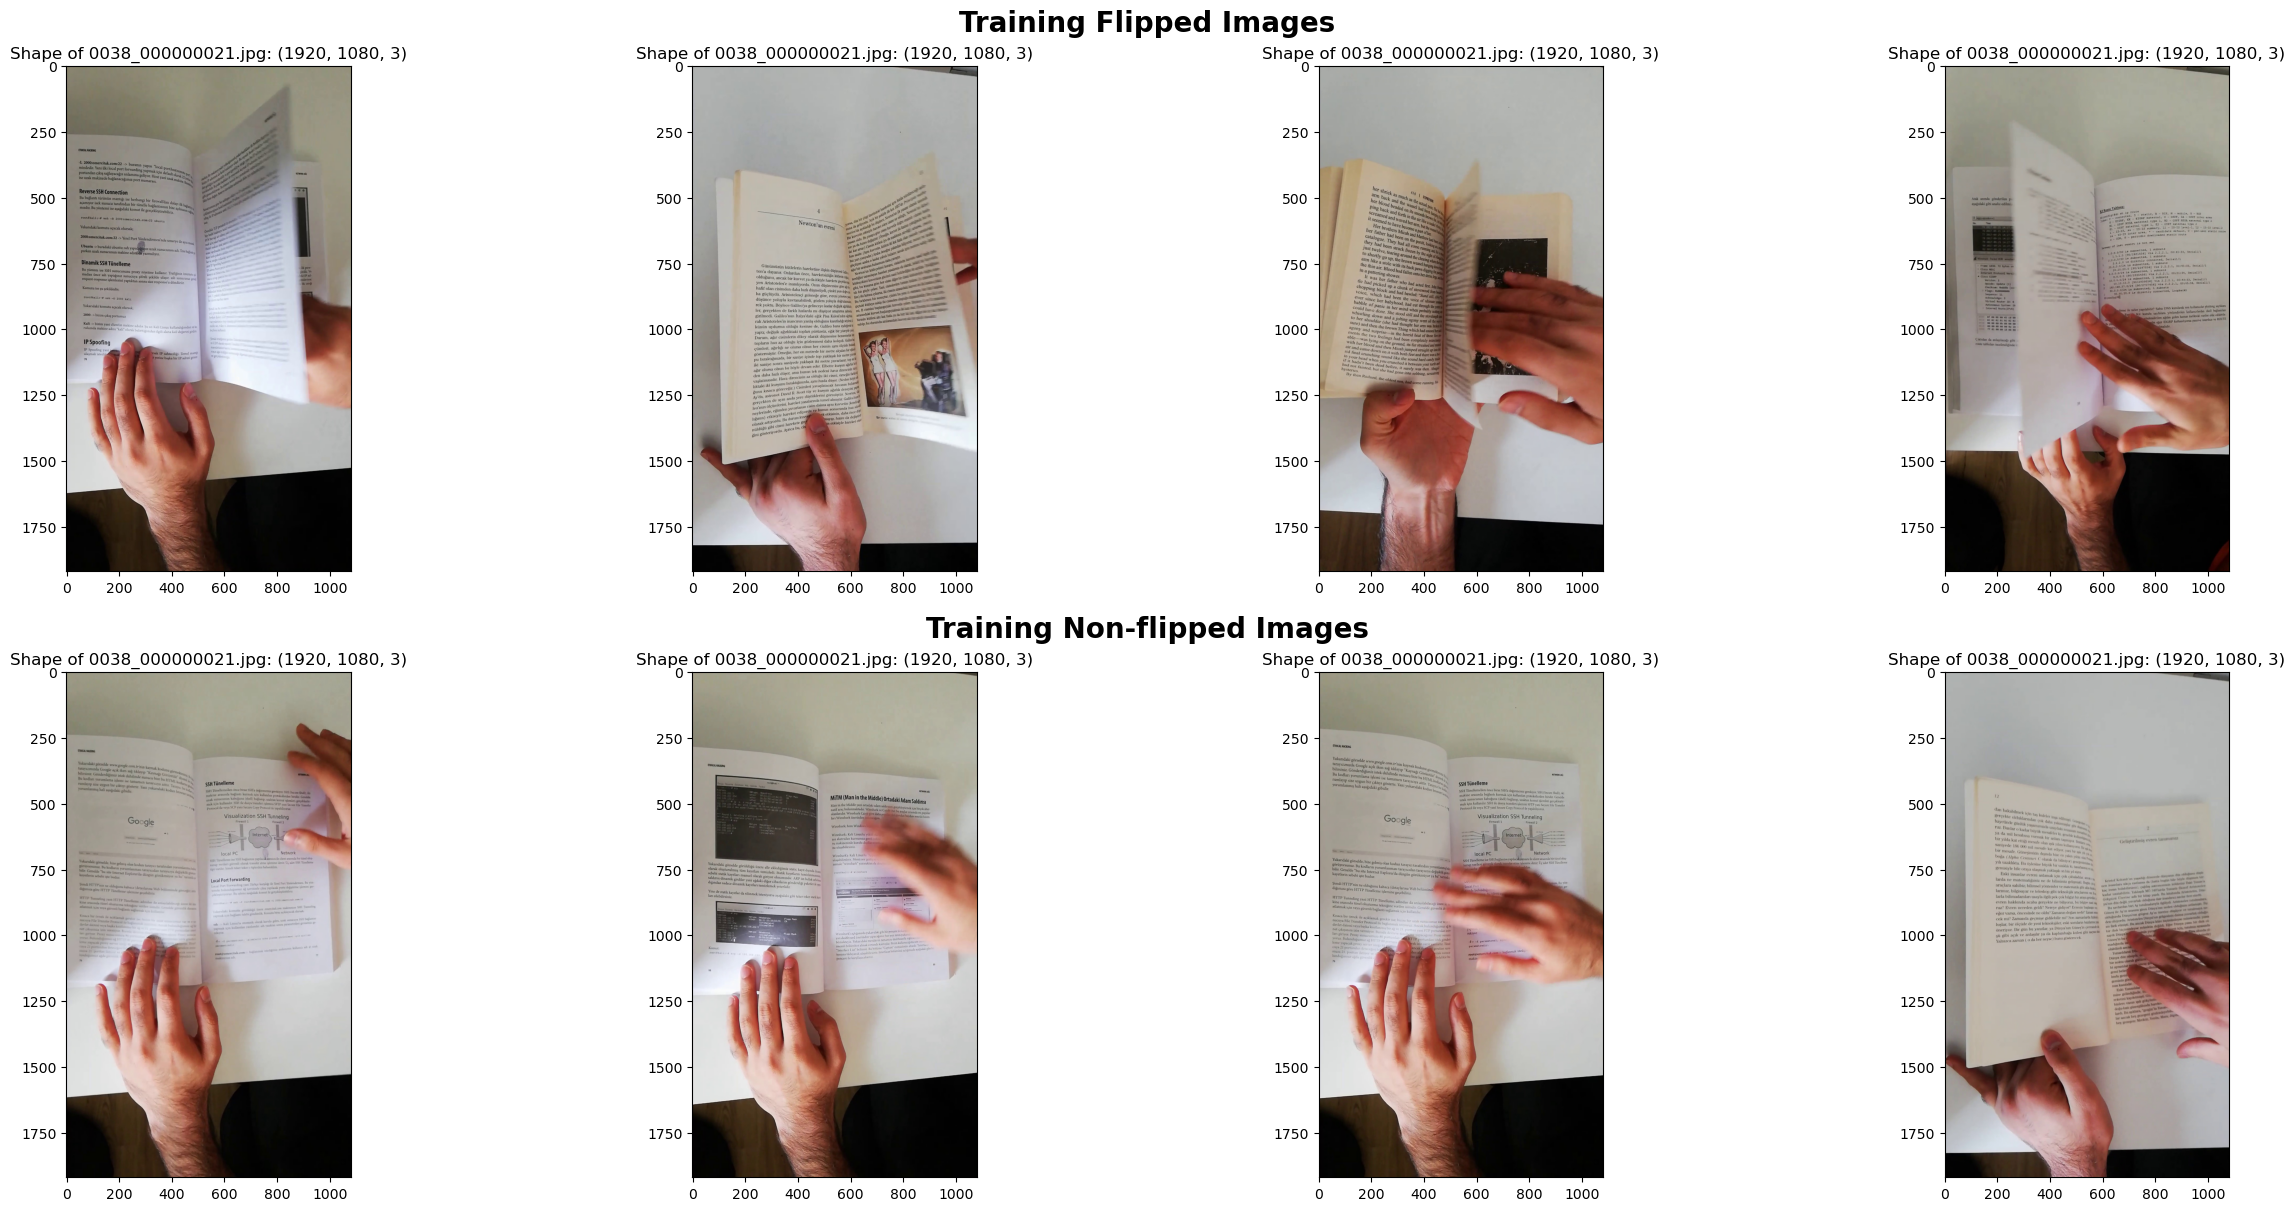

In [6]:
# let's see 4 examples of flipped and non-flipped images 

dic={'Training Flipped Images':[],
     'Training Non-flipped Images':[]}

for i, image_name in enumerate(training_flip[:4]):
    image_path = os.path.join('../APZIVA/images/training/flip',image_name)
    dic['Training Flipped Images'].append(image_path)
    
for i, image_name in enumerate(training_notflip[:4]):
    image_path = os.path.join('../APZIVA/images/training/notflip',image_name)
    dic['Training Non-flipped Images'].append(image_path)


fig = plt.figure(figsize=(25,12),constrained_layout=True)
# # create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(list(dic.keys())[row], fontsize=20, fontweight='bold')

#     # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=4)
    for col, ax in enumerate(axs):
        im = cv2.imread(dic[list(dic.keys())[row]][col])
        ax.imshow(im[:,:,::-1])
        ax.set_title(f"Shape of {image_name}: {im.shape}")


Images are originally in the shape of (1920,1080).

In [7]:
# Let's resize them to size (32,32)
image_height=32
image_width=32
batch_size=16

train = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            validation_split = 0.2)

# for validation and test sets, we would not augment the images
validation = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
test = ImageDataGenerator(rescale = 1/255.0)

# create training set
print('Training set:')
train_generator = train.flow_from_directory("images/training",
                                            target_size = (image_height, image_width),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            classes = ['notflip', 'flip'],
                                            subset = 'training',
                                            seed = 11)

# create validation set
print('\nValidation set:')
validation_generator = validation.flow_from_directory("images/training", # same directory as training data
                                        target_size = (image_height, image_width),
                                        batch_size = batch_size,
                                        class_mode = 'binary',
                                        classes = ['notflip', 'flip'],
                                        subset = 'validation', # set as validation data
                                        seed = 12,
                                        shuffle=False)

# create testing set  
print('\nTest set:')
test_generator = test.flow_from_directory("images/testing",
                                          target_size = (image_height, image_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          classes = ['notflip', 'flip'],
                                          seed = 13,
                                          shuffle=False)


Training set:
Found 1914 images belonging to 2 classes.

Validation set:
Found 478 images belonging to 2 classes.

Test set:
Found 597 images belonging to 2 classes.


In [8]:
# sanity check
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'notflip': 0, 'flip': 1}
{'notflip': 0, 'flip': 1}
{'notflip': 0, 'flip': 1}


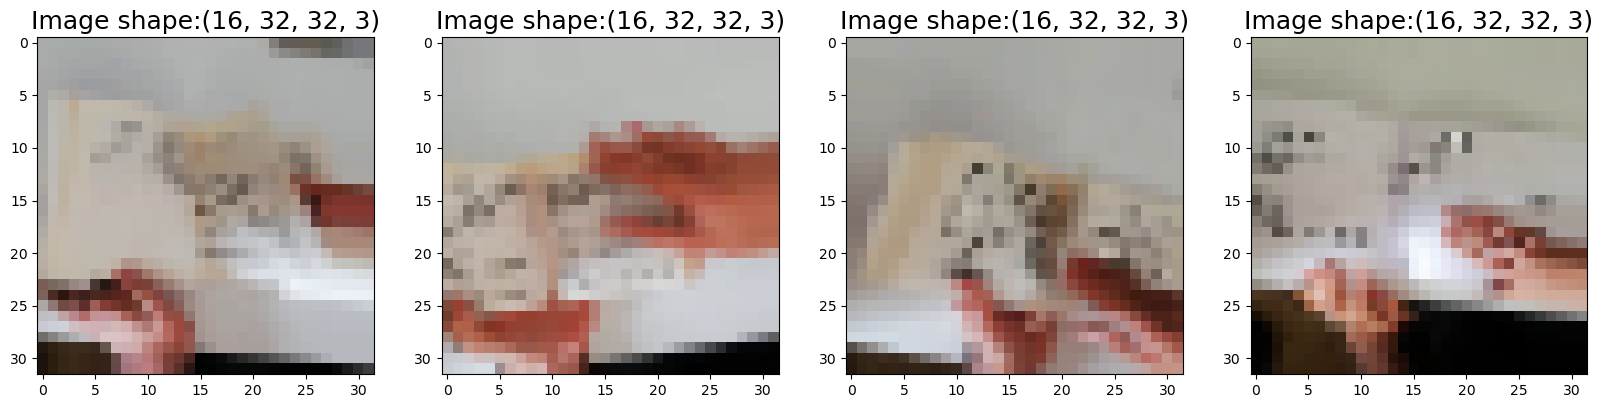

In [9]:
# sanity check image shape
plt.figure(figsize=(20,10)) # specifying the overall grid size

for i in range(4):
    img, label = train_generator.next()
    plt.subplot(1,4,i+1) 
    plt.title(f'Image shape:{img.shape}', fontsize=18)
    plt.imshow(img[i])
plt.show()

# Bayesian Optimization <a class="anchor" id="tuning"></a>

We would use Keras tuner -  BayesianOptimization to tune hyperparameters for the model architecture as below.

In [10]:
def build_model(hp):
    ############### create model object
    model = keras.Sequential()
    
    ################################ add 1ST CONVOLUTIONAL layer    
    model.add(
    layers.Conv2D(
        ######## tune filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=512, step=16),
        ######## add filter size or kernel size, activation function and input shape
        kernel_size=(3,3),
        activation='relu',
        input_shape=(32,32,3)))
    
    ################################ Add MaxPooling
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
        
    ################################ Tune whether to use dropout.        
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    
    ################################ Tune the number of  NEXT CONVOLUTIONAL layers
    for i in range(hp.Int("num_2+_layers", 1, 2)):
        model.add(
        layers.Conv2D(
        ######## tune filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=512, step=16),
        ######## add filter size or kernel size and activation function
        kernel_size=(3,3),
        activation='relu'))
        
        ################################ Add MaxPooling
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        
        ################################ Tune whether to use dropout.        
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=0.25))

    ################################ add FLATTEN layer
    model.add(layers.Flatten())
    
    ################################ Tune the number of  DENSE layers and their dense units.
    for i in range(hp.Int("num_dense_layers", 1, 2)):
        model.add(
            layers.Dense(
                ######## Tune number of units
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=16),
                ######## add the activation function to use
                activation='relu'))

    ################################ Tune whether to use dropout.        
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

    ################################ add an output layer
    model.add(layers.Dense(1, activation="sigmoid"))
    
    ################################ Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=['accuracy'])
    return model

# sanity check if the model builds successfully.
build_model(keras_tuner.HyperParameters())

2023-10-31 19:44:21.249476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-31 19:44:21.249495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to avoid overfitting of model
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 
model_checkpoint = ModelCheckpoint('best_model.h5', 
                                   monitor='val_accuracy', 
                                   mode='max', 
                                   verbose=1, 
                                   save_best_only=True)

tuner = BayesianOptimization(hypermodel=build_model,
                    objective=keras_tuner.Objective("accuracy", direction="max"),
                    max_trials = 5,
                    executions_per_trial=1,
                    seed=8989,
                    overwrite=True,
                    directory='9000')

# search best parameter
with tf.device('/device:GPU:0'):
    tuner.search(train_generator,
               epochs=40,
               validation_data=validation_generator,
               callbacks=[early_stopping, model_checkpoint])
    
# we would experiment 5 trials, one execution only throughout 50 epochs for each trial

Trial 5 Complete [00h 13m 20s]
accuracy: 0.5585162043571472

Best accuracy So Far: 0.9728317856788635
Total elapsed time: 01h 24m 33s


In [18]:
# Get the top model
best_model=tuner.get_best_models(num_models=1)[0]

#summary of best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 192)       884928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 192)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 192)         331968    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 192)         0

# Model evaluation <a class="anchor" id="eva"></a>

In [19]:
# evaluate test set
best_model.evaluate(test_generator)

38/38 [==============================] - 10s 223ms/step - loss: 0.1812 - accuracy: 0.9464


[0.18119753897190094, 0.9463986754417419]

In [20]:
from sklearn.metrics import classification_report

# see how well each class is predicted
preds=best_model.predict(test_generator)
y_test = test_generator.classes
y_pred = np.where(preds > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

38/38 [==============================] - 8s 208ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       307
           1       0.96      0.93      0.94       290

    accuracy                           0.95       597
   macro avg       0.95      0.95      0.95       597
weighted avg       0.95      0.95      0.95       597



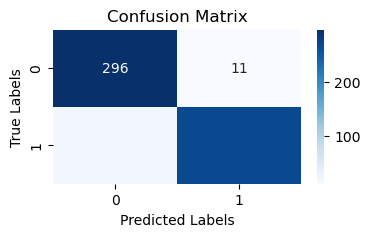

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap plot
plt.figure(figsize=(4,2))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Conclusion <a class="anchor" id="con"></a>

This project is to predict if the page is being flipped using a single image. Thanks to Keras tuner - BayesianOptimization, we have found the optimal model for this dataset, with the accuracy of **0.95** and f1 score **>=0.94** of on both classes. Since the size of dataset is pretty small, let's try using a vision transformer model to see if we can get a better performance. Catch you in the next notebook!